<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Exploration</a></span></li><li><span><a href="#Creating-data-for-time-series-prediction" data-toc-modified-id="Creating-data-for-time-series-prediction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating data for time series prediction</a></span><ul class="toc-item"><li><span><a href="#Creating-the-y_true-fields-for-each-air-quality-metric" data-toc-modified-id="Creating-the-y_true-fields-for-each-air-quality-metric-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Creating the y_true fields for each air quality metric</a></span></li><li><span><a href="#Creating-the-models" data-toc-modified-id="Creating-the-models-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Creating the models</a></span></li><li><span><a href="#Test-performance-of-these-regressor-on-the-train-data" data-toc-modified-id="Test-performance-of-these-regressor-on-the-train-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Test performance of these regressor on the train data</a></span></li></ul></li><li><span><a href="#Generalizing-model-to-5-years-of-data-to-predict" data-toc-modified-id="Generalizing-model-to-5-years-of-data-to-predict-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generalizing model to 5 years of data to predict</a></span><ul class="toc-item"><li><span><a href="#Making-predictions-for-each-air-quality-criteria" data-toc-modified-id="Making-predictions-for-each-air-quality-criteria-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Making predictions for each air quality criteria</a></span></li><li><span><a href="#Saving-predicted-data" data-toc-modified-id="Saving-predicted-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Saving predicted data</a></span></li></ul></li></ul></div>

In [89]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# We load all the appliances
air_quality = pd.read_csv("Data_Files/air_quality/original_air_quality.csv")

# Data Exploration

In [90]:
air_quality.head()

,date,pm25,pm10,o3,no2,3so2,co
0,02/02/2020,15,5,25,7,3,3
1,03/02/2020,13,9,28,5,3,3
2,04/02/2020,22,10,26,14,4,1
3,05/02/2020,21,11,22,9,3,1
4,06/02/2020,24,13,19,10,2,1


# Creating data for time series prediction

We first split the date into 3 field: day, month and year (to which we remove 2015 to have similar scale with the other fields)

In [105]:
x = []

for val in air_quality["date"].to_numpy():
    
    splitted_date = val.split("/")
    
    x.append(
        [int(splitted_date[0]), int(splitted_date[1]), int(splitted_date[2])-2015]
    )
    

In [92]:
air_quality.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', '3so2', ' co'], dtype='object')

## Creating the y_true fields for each air quality metric

In [93]:
y_pm25 = air_quality[" pm25"].to_numpy()
y_pm10 = air_quality[" pm10"].to_numpy()
y_o3 = air_quality[" o3"].to_numpy()
y_no2 = air_quality[" no2"].to_numpy()
y_3so2 = air_quality["3so2"].to_numpy()
y_co = air_quality[" co"].to_numpy()

## Creating the models 
Note that we use multiple unimodal regressor, we could study a multimodal solution

In [95]:
pm25 = RandomForestRegressor()
pm25.fit(x, y_pm25)
pm10 = RandomForestRegressor()
pm10.fit(x, y_pm10)
o3 = RandomForestRegressor()
o3.fit(x, y_o3)
no2 = RandomForestRegressor()
no2.fit(x, y_no2)
so2 = RandomForestRegressor()
so2.fit(x, y_3so2)
co = RandomForestRegressor()
co.fit(x, y_co)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Test performance of these regressor on the train data 

This is to check the quality of the regressor to capture our data patterns: we do not need a lot of forecasting, only to complete missing dates. Thus, we do not care about overfitting.

In [106]:
y_pred = co.predict(x)

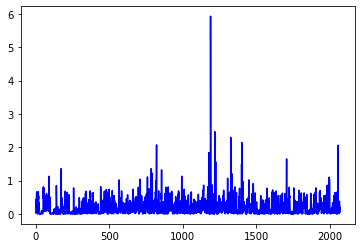

In [113]:
plt.plot(np.abs(y_pred - y_co), 'b') # plotting the absolute difference for each date between true value and predicted value
plt.show()

# Generalizing model to 5 years of data to predict

In [96]:
base = datetime(2020, 8, 1)

num_year = 5

date_list = [(base - timedelta(days=x)).strftime("%d/%m/%Y") for x in range(365*num_year)]

## Making predictions for each air quality criteria

In [98]:
matrix_of_val = []

for date in date_list:
    splitted_date = date.split("/")
    
    x = [int(splitted_date[0]), int(splitted_date[1]), int(splitted_date[2])-2015]
    
    y = [
        pm25.predict([x])[0],
        pm10.predict([x])[0],
        o3.predict([x])[0],
        no2.predict([x])[0],
        so2.predict([x])[0],
        co.predict([x])[0]
    ]
    
    row = [date]
    row.extend(y)
    
    matrix_of_val.append(row)

In [99]:
df = pd.DataFrame(matrix_of_val, columns=air_quality.columns)

## Saving predicted data

In [114]:
df.to_csv("Data_Files/air_quality/edi_air_quality.csv")